In [1]:
%run parameters.ipynb

## Set enviroment variables

## Initiate spark session

## Import required libraries

In [2]:
from operator import itemgetter
from pyspark.sql import SparkSession
from typing import Iterable

import pandas as pd
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import (
    CountVectorizer,
    StringIndexer,
    VectorAssembler,
    Binarizer,
    HashingTF,
    StandardScaler
)
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT
from pyspark.sql import functions as fn
from pyspark.sql.types import ArrayType, DoubleType, FloatType, IntegerType, StringType, BinaryType, StructType, StructField
from pyspark.sql.window import Window
import ast

## Set up the pipeline

In [4]:
stages = []
class TrimByMinVisits(Transformer):
        """Remove visitors with less than declared minimum visits

            Args:
                None

            Returns:
                Update self.data_frame with trimmed dataset
        """
        def __init__(self, minv: int):
            self.minvisits = minv
            super(TrimByMinVisits, self).__init__()
        def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
            my_window = Window.partitionBy('fullVisitorId')
            if self.minvisits > 1:
                return df.select(
                    "*", fn.count('fullVisitorId').\
                    over(my_window).alias("rank")).where(
                        "rank > {}".format(self.minvisits)
                    )
            return df 
stages += [TrimByMinVisits(MIN_VISITS)]

class TimeBetweenVisits(Transformer):
    """Gets the time lapsed between two consecutive visits

                Args:
                    Transformer class

                Returns:
                    TimeBetweenVisits Transformer for the pipeline
    """
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
            partition_col = 'fullVisitorId'
            orderby_sort_col = 'visitStartTime'
            my_window = Window.partitionBy(partition_col
                ).orderBy(orderby_sort_col
                )

            return df.withColumn(
                "prev_value", fn.lag(fn.col(orderby_sort_col)).over(my_window)
                ).withColumn("timeBetweenVisits",fn.when(fn.isnull(
                      fn.col(orderby_sort_col) - fn.col('prev_value')), 0).otherwise(
                      fn.col(orderby_sort_col) - fn.col('prev_value'))
                ).drop('prev_value')
stages += [TimeBetweenVisits()]     

class AssertDataType(Transformer):
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
        df.createOrReplaceTempView("df")
        return spark.sql("""select 
          cast(fullVisitorId as string) as fullVisitorId, 
          cast(visitStartTime as int) as visitStartTime,
          cast(channelGrouping as string) as channelGrouping,
          cast(medium as string) as medium,
          cast(source as string) as source,
          cast(city as string) as city,
          cast(deviceCategory as string) as deviceCategory,
          cast(timeOnSite as float) as timeOnSite,
          cast(timeBetweenVisits as float) as timeBetweenVisits,
          cast(pagePathLevel1 as array<string>) as pagePathLevel1,
          cast(pagePathLevel3 as array<string>) as pagePathLevel2,
          cast(pagePathLevel3 as array<string>) as pagePathLevel3,
          cast(contentGroup4 as array<string>) as contentGroup4,
          cast(visitsIn0 as double) as visitsIn0,
          cast(transactionsIn0 as double) as transactionsIn0
          from df""")
stages += [AssertDataType()]


class FillNa(Transformer):
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
      return df.fillna(0)
stages += [FillNa()] 


scalervect_assembler = [VectorAssembler(
    inputCols=[column], 
    outputCol=column + "_vect"
) for column in VAR_TYPES['X_NUM_COLS']]
stages += scalervect_assembler


scaler = [StandardScaler(
    inputCol=column + "_vect", 
    outputCol=column + "_scaled",
    withStd=True, withMean=False,
) for column in VAR_TYPES['X_NUM_COLS']]
stages += scaler


indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + "_index"
).setHandleInvalid("keep") for column in VAR_TYPES['STRING_COLS']]
stages += indexers


hashingtf = [HashingTF(
    inputCol=column, 
    outputCol=column + "_vector",
    numFeatures=VOCABSIZE_ARRAYCOLS
) for column in VAR_TYPES['ARRAY_COLS']]
stages += hashingtf


binarizer = [Binarizer(
    inputCol=column, 
    outputCol=column + "_binary",
    threshold=0
) for column in VAR_TYPES['Y_COLS']]
stages += binarizer

class GroupBySortByStructPad(Transformer):
    def __init__(self, finalcols_list: Iterable[str], padlen: int):
        self.finalcols_list = finalcols_list
        self.fcol_select = ['sortedByStartTime.'+colstr for colstr in self.finalcols_list]
        self.padlength = padlen
        super(GroupBySortByStructPad, self).__init__()
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
        pad_plus_one = ['channelGrouping_index','medium_index','deviceCategory_index',
                        'source_index', 'city_index','visitsIn0_binary',
                        'transactionsIn0_binary']
        for col in pad_plus_one:
          df = df.withColumn(col, fn.col(col)+1)  
        
        win = Window.partitionBy('fullVisitorId').orderBy('visitStartTime')
        return df.withColumn(
          "rank", fn.dense_rank().over(win)
        ).where(
          'rank <= {}'.format(self.padlength)
        ).groupBy('fullVisitorId').agg(
          fn.array_sort(
            fn.collect_list(
              fn.struct(self.finalcols_list))).alias(
          "sortedByStartTime"
        )).select(self.fcol_select)
        
stages += [GroupBySortByStructPad(VAR_TYPES['FINAL_COLS'], PAD_LEN)]


class PadVector(Transformer):
    def zero_value(self, dataType):
      if dataType == DoubleType():
        return 0.0
      elif dataType == VectorUDT():
        return Vectors.sparse(VOCABSIZE_ARRAYCOLS, [])
  
    def __init__(self, pad_cols: Iterable[str], pad_len: int):
      super(PadVector, self).__init__()
      self.pad_cols = pad_cols
      self.pad_len = pad_len
        
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
      field_datatype = {
        f.name: f.dataType for f in df.schema.fields if f.name in self.pad_cols
      }
      schema_fields = df.schema.fields
      i = df
      for c in self.pad_cols:
        padder = fn.udf(
          lambda ar: ar + [ self.zero_value(field_datatype[c].elementType) \
                           for a in range(self.pad_len - len(ar))], field_datatype[c]
        )
        i = i.withColumn(c, padder(c))
      return i
        
stages += [PadVector(pad_cols = VAR_TYPES['FINAL_COLS'], pad_len = 5)]

class MergeArrayVector(Transformer):
    
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
        def merge_array_vector(arr):
            if len(arr) == 0:
                return arr
            else:
                f = arr[0].toArray()
                for a in arr[1:]:
                    f = f + a.toArray()
                return Vectors.dense(f)
        merge_array_vector_udf = fn.udf(merge_array_vector, VectorUDT())
        return df.withColumn(
            "pagePath_vector_arr",
            fn.concat(
                fn.col("pagePathLevel1_vector"),
                fn.col("pagePathLevel2_vector"),
                fn.col("pagePathLevel3_vector"),
            )
        ).withColumn(
            "pagePath_vector",
            merge_array_vector_udf(fn.col("pagePath_vector_arr"))
        )
stages += [MergeArrayVector()]

class MergeIndexFeatures(Transformer):
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
        array_to_vec = fn.udf(Vectors.dense, VectorUDT())
        return df.withColumn(
                "index_features",
            array_to_vec(
                fn.concat(
                    fn.col("source_index"),
                    fn.col("medium_index"),
                    fn.col("channelGrouping_index"),
                    fn.col("deviceCategory_index")
        )
            )
                )
stages += [MergeIndexFeatures()]

pageIndexAssembler = VectorAssembler(
    inputCols=["index_features", "pagePath_vector"],
    outputCol="features")
stages += [pageIndexAssembler]


class ExtractFeaturesForNN(Transformer):
    def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
        return df.withColumn(
            'label', fn.col('transactionsIn0_binary').getItem(0)
        ).select(
            'features', 'label'
        )
stages += [ExtractFeaturesForNN()]

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

In [ ]:

# class MergePageVectorFeatures(Transformer):
#     def _transform(self, df: fn.DataFrame) -> fn.DataFrame:
# #         array_to_vec = fn.udf(Vectors.dense, VectorUDT())
#         return df.withColumn(
#                 "index_pagevec_features",
#                 fn.concat(
#                     fn.col("index_features"),
#                     fn.col("pagePath_vector")
#         )
#             )
# stages += [MergePageVectorFeatures()]

# Load the libraries required for LSTM network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

In [ ]:
# from elephas.ml_model import ElephasEstimator

In [ ]:
stageNN = []
class BuildNN(Transformer):
    def get_lstm_model():
        model = Sequential()

        # Add Embedding layer
        model.add(Embedding(input_dim=input_dim_embed, output_dim=output_dim_embed, input_length=input_length_embed))

    #     # Add Convolutional Layer
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(PAD_LEN,n_features)))

        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        plot_model(model)
        return model
    
#     def SetElephasEstimator(Transformer):
#         estimator=ElephasEstimator()
#         estimator.set_keras_model_config(model.to_yaml())
#         estimator.set_nb_classes(classes)
#         estimator.set_num_workers(8)
#         estimator.set_epochs(epochs)
#         estimator.set_batch_size(batch_size)
#         estimator.set_verbosity(2)
#         estimator.set_validation_split(0.20)
#         estimator.set_loss('sparse_categorical_crossentropy')
#         estimator.set_metrics(['acc'])

stageNN += [BuildNN]

In [ ]:
def get_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim_embed, output_dim=output_dim_embed, input_length=input_length_embed))

#     # Add Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(PAD_LEN,n_features)))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model)
    return model

In [15]:
from keras.models import Sequential, Model
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, Input, Activation, GRU, Conv1D
from keras.layers import Flatten, TimeDistributed, concatenate, Reshape
from keras.layers import Embedding, Dot, Add, Multiply, Dropout
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

In [26]:
SAMPLE_SIZE = 100000
#SAMPLE_SIZE = 100000

# outputs = output_trans_np[:100000, 3-1]

CUTOFF = 3
NO_EPOCHS = 100
BATCH_SIZE = 512

EMBED_DIM = 64
LSTM_DIM = 128
LEARNING_RATE = 0.001
ACTI = 'relu'
DROPOUT = 0

CHANNELS = 5
NO_DEVICES = [6]
NO_CITIES = [2000]
NO_COMMON_HITS = 1000

def nn_model(use_activation):
    vocab_size = CHANNELS + 1
  
    ### Channels
    input_layer_e = Input(shape=(CUTOFF,),name='event_input')   
    embedding_event = Embedding(input_dim=vocab_size,output_dim=EMBED_DIM,input_length=CUTOFF,name='sequence_embedding')(input_layer_e)

    ### Devices
    input_layer_d = Input(shape=(CUTOFF,),name='device_input')
    embedding_device = Embedding(input_dim=NO_DEVICES[0]+1,output_dim=EMBED_DIM,input_length=CUTOFF,name='device_embedding')(input_layer_d)
    
    ### City
    input_layer_c = Input(shape=(CUTOFF,),name='city_input')
    embedding_city = Embedding(input_dim=NO_CITIES[0]+1,output_dim=EMBED_DIM,input_length=CUTOFF,name='city_embedding')(input_layer_c)
     
    ### Hits
    hits_input_layer = Input(shape=(CUTOFF,NO_COMMON_HITS,),name='hit_input')
    hit_convolution = Conv1D(filters=16,kernel_size=64,padding="same",name='hit_conv')(hits_input_layer)
      
    ## Time on site
    tos_input_layer = Input(shape=(CUTOFF,),name='tos_input')
    tos_transformed = Reshape([CUTOFF,1])(tos_input_layer)
    
    ## Visit No
    visitno_input_layer = Input(shape=(CUTOFF,),name='visitno_input')
    visitno_transformed = Reshape([CUTOFF,1])(visitno_input_layer)
    
    emb_vector = [embedding_event]
    emb_vector.append(embedding_device)
    emb_vector.append(embedding_city)
    emb_vector.append(hit_convolution)      
    emb_vector.append(tos_transformed)
    emb_vector.append(visitno_transformed)
      
    input_embeddings = concatenate(emb_vector)
    
    embedding_phi = Embedding(input_dim=vocab_size,output_dim=1,input_length=CUTOFF,name='phi_embedding')(input_layer_e)
    embedding_mu = Embedding(input_dim=vocab_size,output_dim=1,input_length=CUTOFF,name='mu_embedding')(input_layer_e)
        
    time_input_layer = Input(shape=(CUTOFF,1),name='time_input')
    
    multiply = Multiply(name='multiplication')([embedding_mu,time_input_layer])
    added = Add(name='addition')([embedding_phi,multiply])
    time_attention = Activation(activation='sigmoid',name='attention_activation')(added)
    
    product = Multiply(name='product')([input_embeddings,time_attention])

    lstm_1 = LSTM(LSTM_DIM, return_sequences=True,activation=ACTI)(product)
    drop_1 = Dropout(DROPOUT)(lstm_1) 
    lstm_2 = LSTM(LSTM_DIM, return_sequences=True,activation=ACTI)(drop_1)    
    drop_f = Dropout(DROPOUT)(lstm_2)
    
    #### New addition: attention output layer
    if use_activation:
      input_attention_layer = TimeDistributed(Dense(1))(drop_f)
      attention_output_layer = TimeDistributed(Dense(1, activation='softmax'))(input_attention_layer)
      attention_product = Multiply(name='attention_product')([drop_f, attention_output_layer])

      output_layer = TimeDistributed(Dense(1, activation='sigmoid'))(attention_product)
#     else:
#       output_layer = TimeDistributed(Dense(1,activation='sigmoid'))(drop_f)
    else:
      flattened_output = Flatten()(drop_f)
      output_layer = Dense(1,activation='sigmoid')(flattened_output)
    
    model = Model(inputs=[input_layer_e,input_layer_d,input_layer_c,hits_input_layer,time_input_layer,tos_input_layer,visitno_input_layer],outputs=[output_layer])
    
    opt = Nadam(lr=LEARNING_RATE) #, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

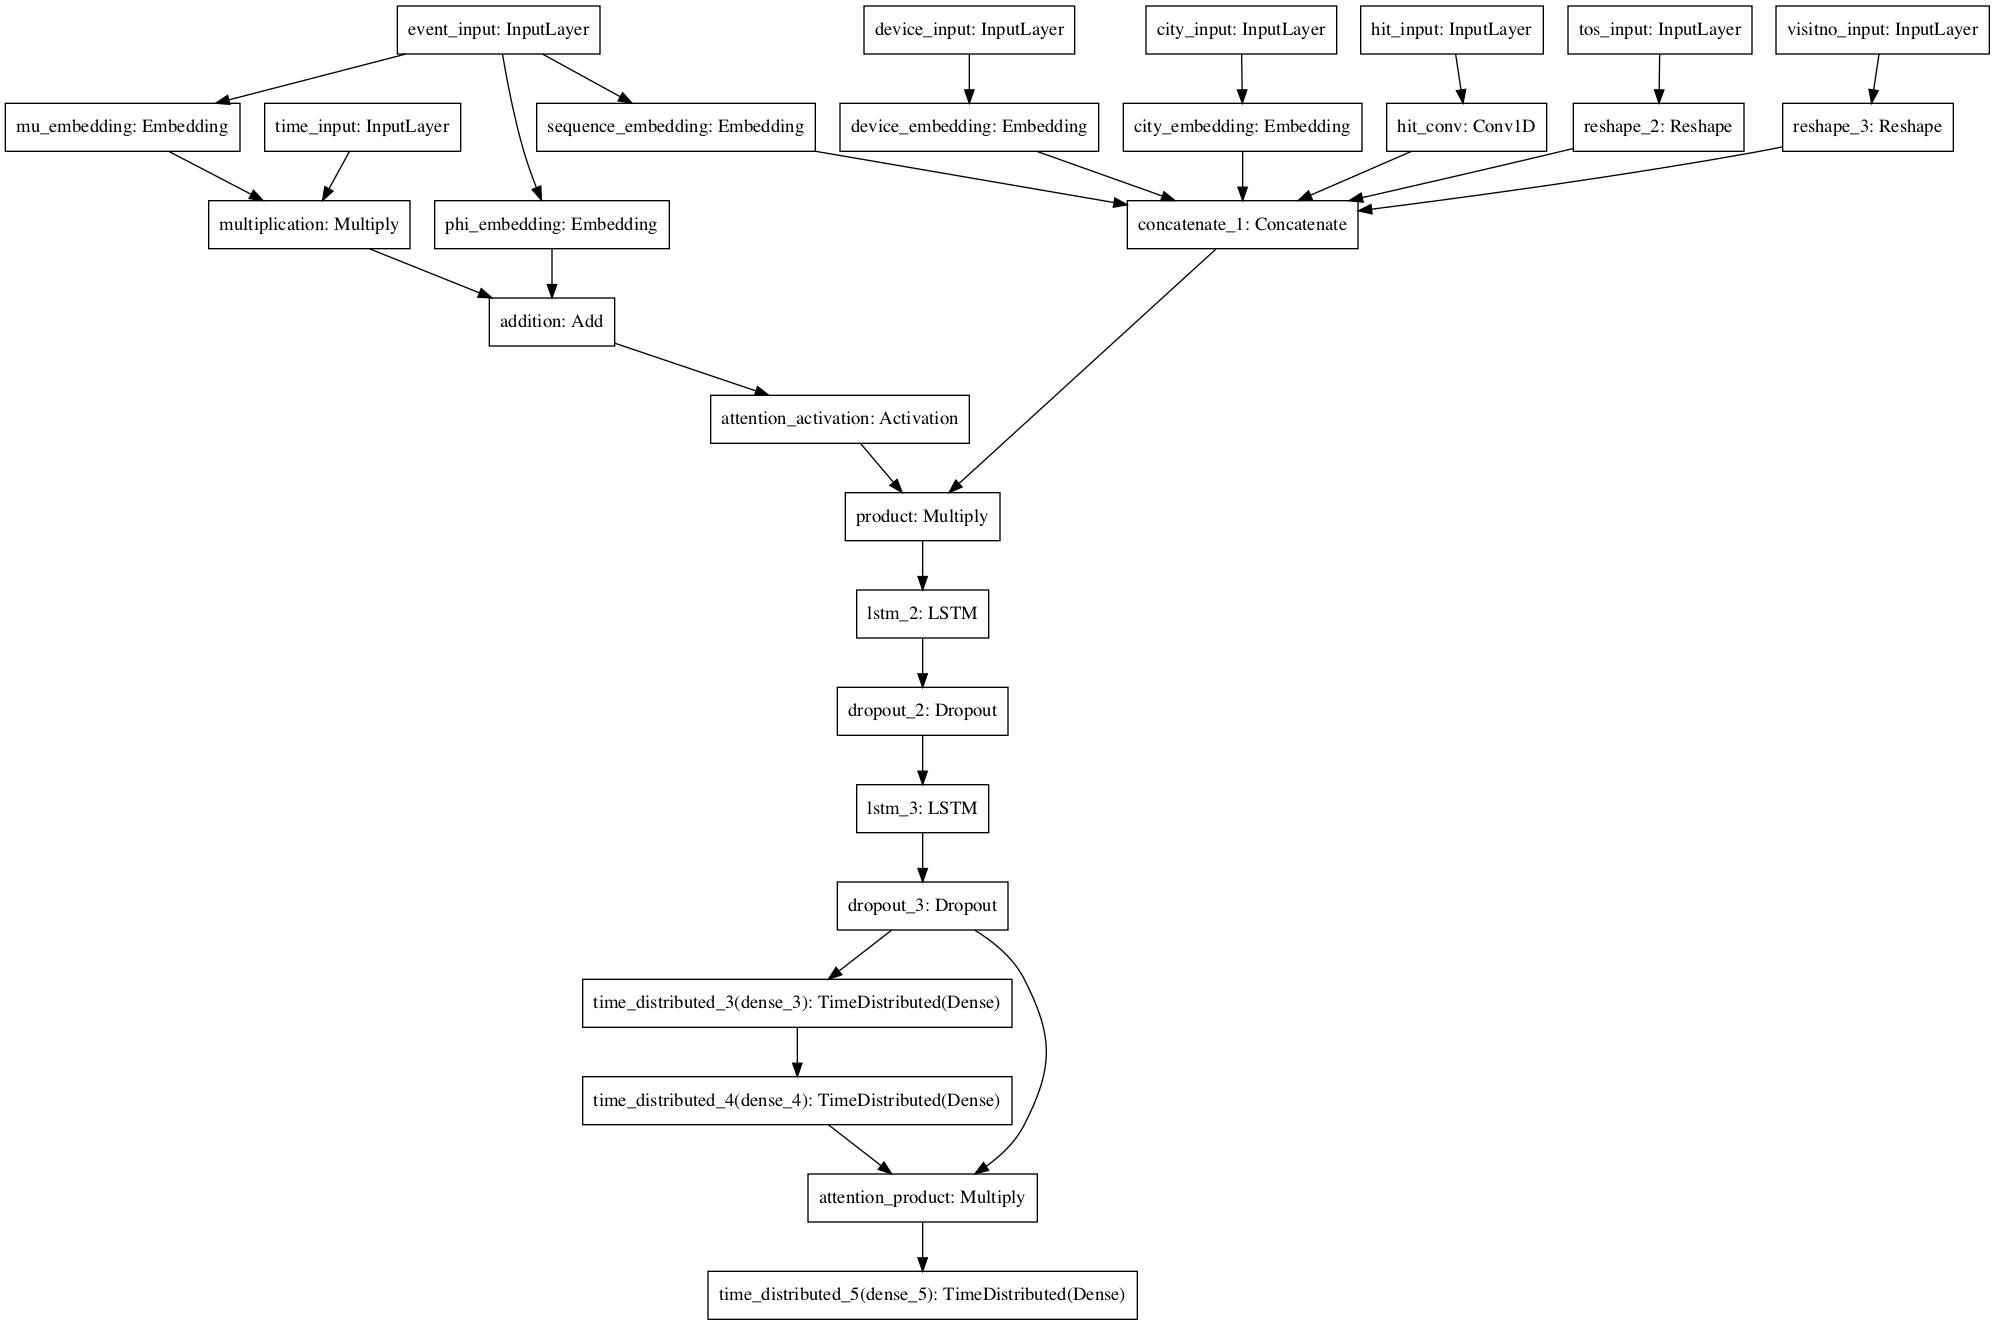

In [28]:
from keras.utils import plot_model
model = nn_model(use_activation=True)
plot_model(model)